### SHRED applied to SST dataset

This iPython notebook gives an introductory walkthrough to using SHRED models.  The dataset we consider is weekly mean sea-surface temperature as given by the NOAA Optimum Interpolation SST V2 dataset (https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html).

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as 
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

We first randomly select 3 sensor locations and set the trajectory length (lags) to 52, corresponding to one year of measurements.

In [4]:
import numpy as np
from processdata import load_data
from processdata import TimeSeriesDataset
import models
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

num_sensors = 3 
lags = 52
load_X = load_data('SST')
n = load_X.shape[0]
m = load_X.shape[1]
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

We now select indices to divide the data into training, validation, and test sets.

In [5]:
train_indices = np.random.choice(n - lags, size=1000, replace=False)
mask = np.ones(n - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[::2]
test_indices = valid_test_indices[1::2]

sklearn's MinMaxScaler is used to preprocess the data for training and we generate input/output pairs for the training, validation, and test sets. 

In [6]:
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

### Generate input sequences to a SHRED model
all_data_in = np.zeros((n - lags, lags, num_sensors))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

### -1 to have output be at the same time as final sensor measurements
train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

We train the model using the training and validation datasets.

In [7]:
shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, verbose=True, patience=5)

Training epoch 1
Error tensor(0.4715)
Training epoch 20
Error tensor(0.2239)
Training epoch 40
Error tensor(0.2157)
Training epoch 60
Error tensor(0.2125)
Training epoch 80
Error tensor(0.2067)
Training epoch 100
Error tensor(0.2038)
Training epoch 120
Error tensor(0.1980)
Training epoch 140
Error tensor(0.1857)
Training epoch 160
Error tensor(0.1735)
Training epoch 180
Error tensor(0.1575)
Training epoch 200
Error tensor(0.1477)
Training epoch 220
Error tensor(0.1415)
Training epoch 240
Error tensor(0.1368)
Training epoch 260
Error tensor(0.1317)
Training epoch 280
Error tensor(0.1324)
Training epoch 300
Error tensor(0.1256)
Training epoch 320
Error tensor(0.1227)
Training epoch 340
Error tensor(0.1207)
Training epoch 360
Error tensor(0.1201)
Training epoch 380
Error tensor(0.1192)
Training epoch 400
Error tensor(0.1170)
Training epoch 420
Error tensor(0.1171)
Training epoch 440
Error tensor(0.1156)
Training epoch 460
Error tensor(0.1150)
Training epoch 480
Error tensor(0.1146)
Traini

Finally, we generate reconstructions from the test set and print mean square error compared to the ground truth.

In [7]:
test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
print(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

NameError: name 'shred' is not defined

In [123]:
import pandas as pd

def parse_file(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()

    data = []
    for line in lines:
        if "Training epoch" in line:
            epoch = int(line.split()[-1])
        elif "Error" in line:
            error = float(line.split()[-1].replace("tensor(", "").replace(")", ""))
            data.append({'epoch': epoch, 'error': error})

    return pd.DataFrame(data)

df = parse_file("training_result.txt")

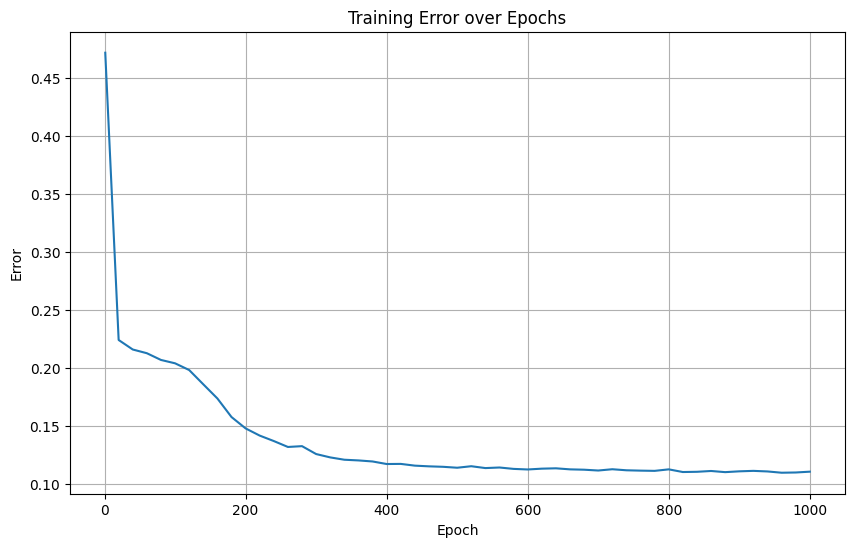

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(df['epoch'], df['error'])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Training Error over Epochs')
plt.grid(True)
plt.show()

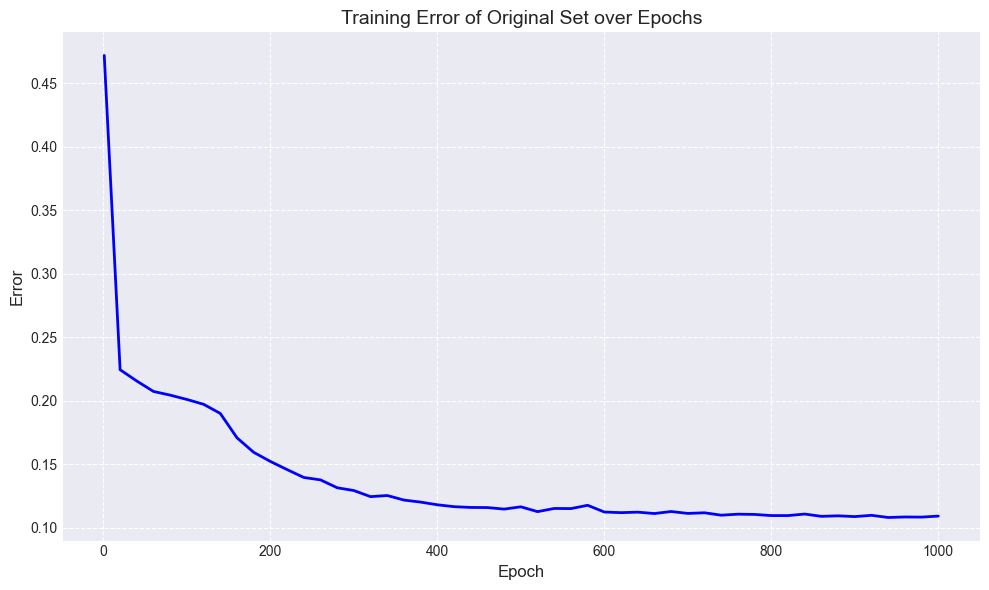

In [125]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['error'], color='blue', linewidth=2)

# Adding labels and title
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Error', fontsize=12)
plt.title('Training Error of Original Set over Epochs', fontsize=14)

# Adjusting tick label font sizes
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Adding grid lines
plt.grid(True, linestyle='--')

# Removing top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adding a legend if necessary
# plt.legend()

# Displaying the plot
plt.tight_layout()
plt.show()


In [22]:
# inital, unchanged parameters
shred_init = shred
validation_errors_init = validation_errors
test_recons_init = sc.inverse_transform(shred_init(test_dataset.X).detach().cpu().numpy())
test_ground_truth_init = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
print(np.linalg.norm(test_recons_init - test_ground_truth_init) / np.linalg.norm(test_ground_truth_init))

0.020313913


In [11]:
def run_experiment(num_sensors, lags, num_epochs, noise_std):
    load_X = load_data('SST')
    n = load_X.shape[0]
    m = load_X.shape[1]
    sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

    train_indices = np.random.choice(n - lags, size=1000, replace=False)
    mask = np.ones(n - lags)
    mask[train_indices] = 0
    valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
    valid_indices = valid_test_indices[::2]
    test_indices = valid_test_indices[1::2]

    sc = MinMaxScaler()
    sc = sc.fit(load_X[train_indices])
    transformed_X = sc.transform(load_X)

    ### Generate input sequences to a SHRED model
    all_data_in = np.zeros((n - lags, lags, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, sensor_locations]
    
    # Add Gaussian noise to the input data
    noise = np.random.normal(0, noise_std, all_data_in.shape)
    all_data_in += noise

    ### Generate training v|alidation and test datasets both for reconstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    ### -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=num_epochs, lr=1e-3, verbose=True, patience=5)

    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    test_performance = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    print(test_performance)
    
    return shred, validation_errors, test_performance

In [35]:
num_sensors = 3
lags = 52
num_epochs = 1000
noise_std = 0

shred_OG, validation_errors_OG, test_performance_OG = run_experiment(num_sensors, lags, num_epochs, noise_std)

Training epoch 1
Error tensor(0.4717)
Training epoch 20
Error tensor(0.2243)
Training epoch 40
Error tensor(0.2154)
Training epoch 60
Error tensor(0.2072)
Training epoch 80
Error tensor(0.2043)
Training epoch 100
Error tensor(0.2009)
Training epoch 120
Error tensor(0.1971)
Training epoch 140
Error tensor(0.1899)
Training epoch 160
Error tensor(0.1707)
Training epoch 180
Error tensor(0.1593)
Training epoch 200
Error tensor(0.1521)
Training epoch 220
Error tensor(0.1457)
Training epoch 240
Error tensor(0.1395)
Training epoch 260
Error tensor(0.1376)
Training epoch 280
Error tensor(0.1314)
Training epoch 300
Error tensor(0.1292)
Training epoch 320
Error tensor(0.1244)
Training epoch 340
Error tensor(0.1253)
Training epoch 360
Error tensor(0.1217)
Training epoch 380
Error tensor(0.1201)
Training epoch 400
Error tensor(0.1180)
Training epoch 420
Error tensor(0.1165)
Training epoch 440
Error tensor(0.1159)
Training epoch 460
Error tensor(0.1158)
Training epoch 480
Error tensor(0.1146)
Traini

In [52]:
num_sensors_range = range(1, 11)  # change this to the range you want
lags = 52
num_epochs = 200
noise_std = 0

# Dictionaries to store validation errors and test performance for each experiment
validation_errors_dict_sensor = {}
test_performance_dict_sensor = {}

for num_sensors in num_sensors_range:
    print(f"Running experiment with {num_sensors} sensors...")
    shred_sensor, validation_errors_sensor, test_performance_sensor = run_experiment(num_sensors, lags, num_epochs, noise_std)

    # Store validation errors and test performance
    validation_errors_dict_sensor[num_sensors] = validation_errors_sensor
    test_performance_dict_sensor[num_sensors] = test_performance_sensor

Running experiment with 1 sensors...
Training epoch 1
Error tensor(0.4772)
Training epoch 20
Error tensor(0.3094)
Training epoch 40
Error tensor(0.2708)
Training epoch 60
Error tensor(0.2634)
Training epoch 80
Error tensor(0.2448)
Training epoch 100
Error tensor(0.2445)
Training epoch 120
Error tensor(0.2336)
Training epoch 140
Error tensor(0.2239)
Training epoch 160
Error tensor(0.2201)
Training epoch 180
Error tensor(0.2076)
Training epoch 200
Error tensor(0.1976)
0.037010048
Running experiment with 2 sensors...
Training epoch 1
Error tensor(0.4747)
Training epoch 20
Error tensor(0.2423)
Training epoch 40
Error tensor(0.2184)
Training epoch 60
Error tensor(0.2164)
Training epoch 80
Error tensor(0.2110)
Training epoch 100
Error tensor(0.2083)
Training epoch 120
Error tensor(0.2070)
Training epoch 140
Error tensor(0.2036)
Training epoch 160
Error tensor(0.1825)
Training epoch 180
Error tensor(0.1765)
Training epoch 200
Error tensor(0.1681)
0.03090403
Running experiment with 3 sensors..

In [53]:
# Now you can analyze the results
for num_sensors in num_sensors_range:
    print(f"Number of sensors: {num_sensors}")
    print(f"Validation errors: {validation_errors_dict_sensor[num_sensors]}")
    print(f"Test performance: {test_performance_dict_sensor[num_sensors]}")

Number of sensors: 1
Validation errors: [0.47717038 0.30937362 0.27081978 0.26341316 0.244759   0.24452896
 0.23361872 0.22393301 0.22010581 0.20763348 0.19755055]
Test performance: 0.03701004758477211
Number of sensors: 2
Validation errors: [0.47469294 0.24228601 0.2184323  0.21637061 0.21098565 0.20831874
 0.20698734 0.20358671 0.18254839 0.17650084 0.1680729 ]
Test performance: 0.030904030427336693
Number of sensors: 3
Validation errors: [0.47087264 0.22639237 0.21855603 0.21525306 0.20879394 0.18876235
 0.17909719 0.1723513  0.16424957 0.15907422 0.15845798]
Test performance: 0.02897825464606285
Number of sensors: 4
Validation errors: [0.47330824 0.22541602 0.21624291 0.21185838 0.20761707 0.20356207
 0.1909759  0.17752565 0.17367949 0.16504112 0.16183627]
Test performance: 0.029456377029418945
Number of sensors: 5
Validation errors: [0.48702937 0.22488187 0.21795745 0.21326663 0.20543619 0.19525659
 0.18215397 0.1668828  0.15794198 0.15158081 0.14509451]
Test performance: 0.026573

C:\Users\najib\AppData\Local\Temp\ipykernel_31752\1610615493.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


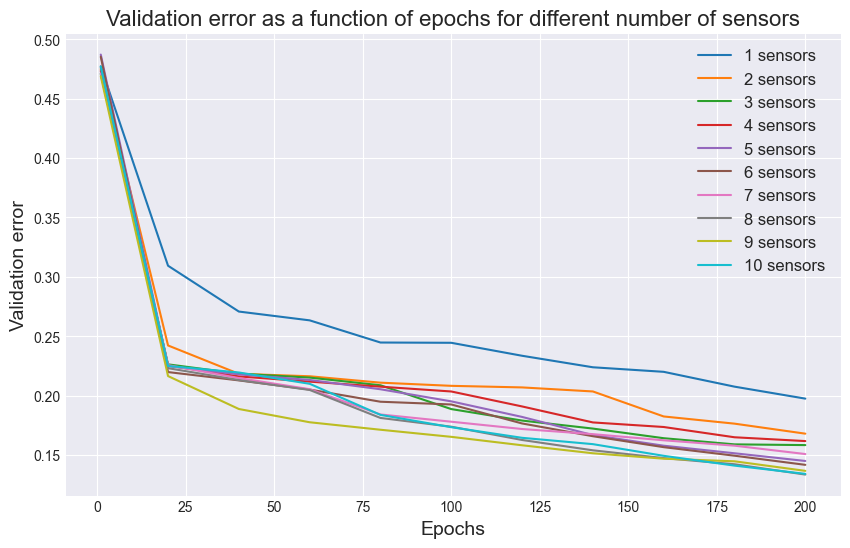

C:\Users\najib\AppData\Local\Temp\ipykernel_31752\1610615493.py:30: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


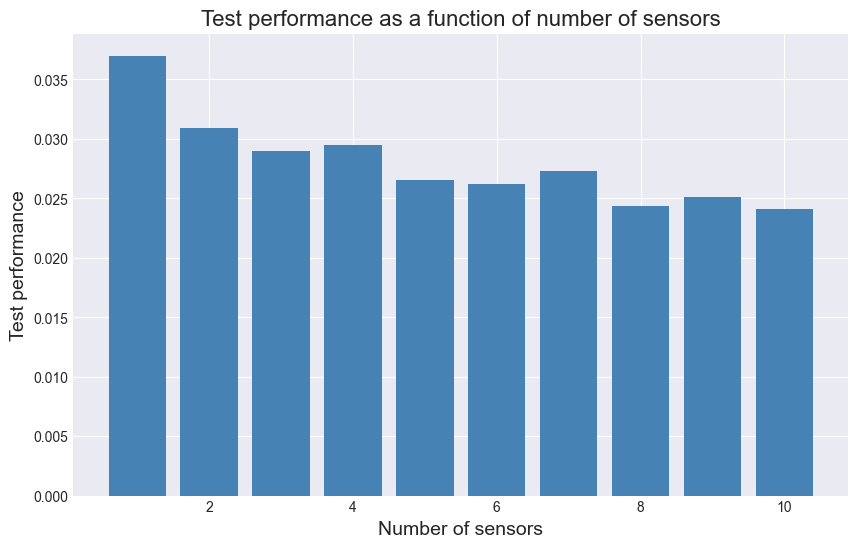

In [58]:
import matplotlib.pyplot as plt

# Set a theme
plt.style.use('seaborn-darkgrid')

# Create a new figure with a custom size (you can adjust the size as needed)
fig, ax = plt.subplots(figsize=(10, 6))

# Define the epoch range
epochs = [1, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]

# Plot the validation errors for each number of sensors
for num_sensors in sorted(validation_errors_dict_sensor.keys()):
    ax.plot(epochs, validation_errors_dict_sensor[num_sensors], label=f"{num_sensors} sensors")

# Set the labels for the x and y axis
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Validation error', fontsize=14)

# Set a title for the plot
ax.set_title('Validation error as a function of epochs for different number of sensors', fontsize=16)

# Add a legend to the plot
ax.legend(fontsize=12)

# Show the plot
plt.show()

# Set a theme
plt.style.use('seaborn-darkgrid')

# Create a new figure with a custom size (you can adjust the size as needed)
fig, ax = plt.subplots(figsize=(10, 6))

# Define the sensor range and test performance
num_sensors_range = sorted(test_performance_dict_sensor.keys())
test_performance_values = [test_performance_dict_sensor[num_sensors] for num_sensors in num_sensors_range]

# Create the bar plot
ax.bar(num_sensors_range, test_performance_values, color='steelblue')

# Set the labels for the x and y axis
ax.set_xlabel('Number of sensors', fontsize=14)
ax.set_ylabel('Test performance', fontsize=14)

# Set a title for the plot
ax.set_title('Test performance as a function of number of sensors', fontsize=16)

# Show the plot
plt.show()


In [23]:
num_sensors = 3
lags_range = [0, 1, 5, 10, 15, 20, 30, 40, 50, 60, 75, 104, 156, 208, 260]  # change this to the range you want
num_epochs = 200
noise_std = 0

# Dictionaries to store validation errors and test performance for each experiment
validation_errors_dict_lag = {}
test_performance_dict_lag = {}

for lags in lags_range:
    print(f"Running experiment with {lags} lag...")
    shred_lag, validation_errors_lag, test_performance_lag = run_experiment(num_sensors, lags, num_epochs, noise_std)

    # Store validation errors and test performance
    validation_errors_dict_lag[lags] = validation_errors_lag
    test_performance_dict_lag[lags] = test_performance_lag

Running experiment with 0 lag...
Training epoch 1
Error tensor(nan)
Training epoch 20
Error tensor(nan)
Training epoch 40
Error tensor(nan)
Training epoch 60
Error tensor(nan)
Training epoch 80
Error tensor(nan)
nan
Running experiment with 1 lag...
Training epoch 1
Error tensor(0.5490)
Training epoch 20
Error tensor(0.3063)
Training epoch 40
Error tensor(0.3079)
Training epoch 60
Error tensor(0.2982)
Training epoch 80
Error tensor(0.2949)
Training epoch 100
Error tensor(0.2933)
Training epoch 120
Error tensor(0.2965)
Training epoch 140
Error tensor(0.2972)
Training epoch 160
Error tensor(0.2927)
Training epoch 180
Error tensor(0.2919)
Training epoch 200
Error tensor(0.2936)
0.05960698
Running experiment with 5 lag...
Training epoch 1
Error tensor(0.4780)
Training epoch 20
Error tensor(0.2770)
Training epoch 40
Error tensor(0.2497)
Training epoch 60
Error tensor(0.2447)
Training epoch 80
Error tensor(0.2416)
Training epoch 100
Error tensor(0.2361)
Training epoch 120
Error tensor(0.2351)

In [41]:
# Now you can analyze the results
for lags in lags_range:
    print(f"Amount of lag: {lags}")
    print(f"Lag Validation errors: {validation_errors_dict_lag[lags]}")
    print(f"Lag Test performance: {test_performance_dict_lag[lags]}")

Amount of lag: 0
Lag Validation errors: tensor([nan, nan, nan, nan, nan])
Lag Test performance: nan
Amount of lag: 1
Lag Validation errors: [0.54904425 0.30629933 0.30790162 0.29816097 0.29487538 0.2933234
 0.29648122 0.29716828 0.29268983 0.29194131 0.2936067 ]
Lag Test performance: 0.05960698053240776
Amount of lag: 5
Lag Validation errors: [0.47799838 0.2769882  0.2496582  0.2446567  0.24157408 0.23608409
 0.23508015 0.23338556 0.23031339 0.23365404 0.23170793]
Lag Test performance: 0.04380960017442703
Amount of lag: 10
Lag Validation errors: [0.4817748  0.24327047 0.22828718 0.2246699  0.22240768 0.21819365
 0.21741067 0.21065825 0.20758022 0.20620926 0.20129153]
Lag Test performance: 0.035469263792037964
Amount of lag: 15
Lag Validation errors: [0.46722952 0.22046433 0.20758675 0.20007391 0.19590285 0.19030492
 0.18843439 0.18038027 0.1786081  0.1690981  0.16334909]
Lag Test performance: 0.02970941923558712
Amount of lag: 20
Lag Validation errors: [0.48270515 0.2381678  0.22200692

C:\Users\najib\AppData\Local\Temp\ipykernel_31752\595074806.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


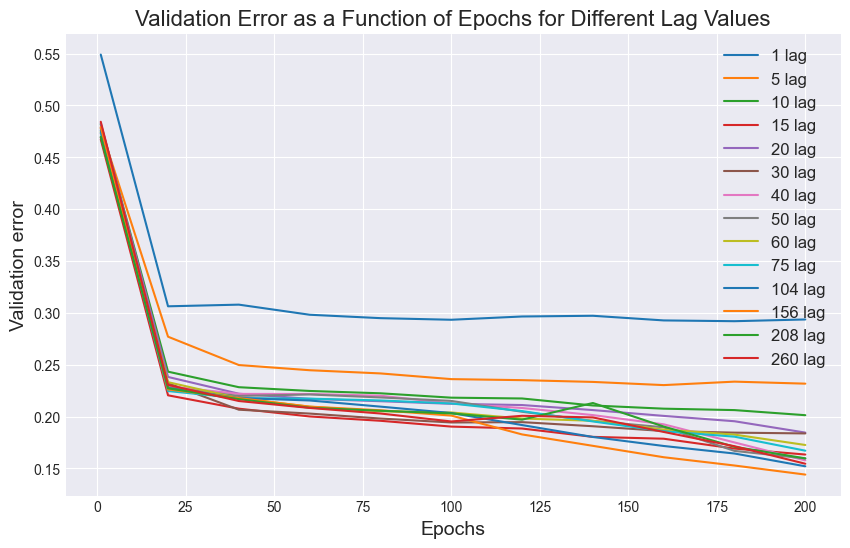

C:\Users\najib\AppData\Local\Temp\ipykernel_31752\595074806.py:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


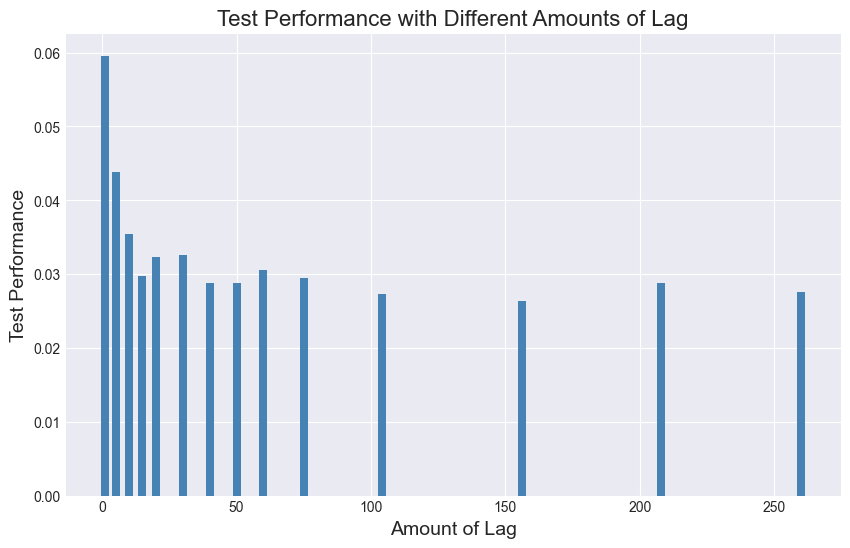

In [115]:
# Set a theme
plt.style.use('seaborn-darkgrid')

# Create a new figure with a custom size
fig, ax = plt.subplots(figsize=(10, 6))

# Define the epoch range
epochs = [1, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]

# Plot the validation errors for each lag
for lags in sorted(validation_errors_dict_lag.keys()):
    if (lags != 0):
        ax.plot(epochs, validation_errors_dict_lag[lags], label=f"{lags} lag")

# Set the labels for the x and y axis
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Validation error', fontsize=14)

# Set a title for the plot
ax.set_title('Validation Error as a Function of Epochs for Different Lag Values', fontsize=16)

# Add a legend to the plot
ax.legend(fontsize=12, loc='upper right')

# Show the plot
plt.show()

import matplotlib.pyplot as plt
import numpy as np

# Set a theme
plt.style.use('seaborn-darkgrid')

# Create a new figure with a custom size
fig, ax = plt.subplots(figsize=(10, 6))

# Define the lag range and test performance
lags_range = sorted(test_performance_dict_lag.keys())
test_performance_values = [test_performance_dict_lag[lag] for lag in lags_range]

# Create the bar plot with thicker bars
bar_width = 3 # Adjust as needed
ax.bar(lags_range, test_performance_values, width=bar_width, color='steelblue')

# Set the labels for the x and y axis
ax.set_xlabel('Amount of Lag', fontsize=14)
ax.set_ylabel('Test Performance', fontsize=14)

# Set a title for the plot
ax.set_title('Test Performance with Different Amounts of Lag', fontsize=16)

# Show the plot
plt.show()



In [28]:
noise_range = range(0, 11)  # change this to the range you want
num_sensors = 3
lags = 52
num_epochs = 200

# Dictionaries to store validation errors and test performance for each experiment
validation_errors_dict_noise = {}
test_performance_dict_noise = {}

for noise_std in noise_range:
    print(f"Running experiment with noise standard deviation {noise_std}...")
    shred_noise, validation_errors_noise, test_performance_noise = run_experiment(num_sensors, lags, num_epochs, noise_std)

    # Store validation errors and test performance
    validation_errors_dict_noise[noise_std] = validation_errors_noise
    test_performance_dict_noise[noise_std] = test_performance_noise

Running experiment with noise standard deviation 0...
Training epoch 1
Error tensor(0.4695)
Training epoch 20
Error tensor(0.2223)
Training epoch 40
Error tensor(0.2163)
Training epoch 60
Error tensor(0.2143)
Training epoch 80
Error tensor(0.2062)
Training epoch 100
Error tensor(0.1991)
Training epoch 120
Error tensor(0.1969)
Training epoch 140
Error tensor(0.1850)
Training epoch 160
Error tensor(0.1785)
Training epoch 180
Error tensor(0.1669)
Training epoch 200
Error tensor(0.1612)
0.029217888
Running experiment with noise standard deviation 1...
Training epoch 1
Error tensor(0.4781)
Training epoch 20
Error tensor(0.3143)
Training epoch 40
Error tensor(0.3122)
Training epoch 60
Error tensor(0.3197)
Training epoch 80
Error tensor(0.3168)
Training epoch 100
Error tensor(0.3210)
Training epoch 120
Error tensor(0.3238)
Training epoch 140
Error tensor(0.3350)
0.06520512
Running experiment with noise standard deviation 2...
Training epoch 1
Error tensor(0.4790)
Training epoch 20
Error tenso

In [46]:
# Now you can analyze the results
for noise_std in noise_range:
    print(f"Noise standard deviation: {noise_std}")
    print(f"Validation errors: {validation_errors_dict_noise[noise_std]}")
    print(f"Test performance: {test_performance_dict_noise[noise_std]}") 

Noise standard deviation: 0
Validation errors: [0.46947566 0.22229926 0.21627042 0.21428573 0.20620793 0.1990769
 0.19688903 0.1850002  0.17853345 0.16694672 0.16119364]
Test performance: 0.029217887669801712
Noise standard deviation: 1
Validation errors: tensor([0.4781, 0.3143, 0.3122, 0.3197, 0.3168, 0.3210, 0.3238, 0.3350])
Test performance: 0.06520511955022812
Noise standard deviation: 2
Validation errors: tensor([0.4790, 0.4295, 0.4449, 0.4662, 0.4742, 0.4816, 0.4892])
Test performance: 0.09817108511924744
Noise standard deviation: 3
Validation errors: tensor([0.4716, 0.4615, 0.4920, 0.5296, 0.5298, 0.5273, 0.5338])
Test performance: 0.13055545091629028
Noise standard deviation: 4
Validation errors: tensor([0.4752, 0.4661, 0.5116, 0.5387, 0.5338, 0.5332, 0.5387])
Test performance: 0.13374850153923035
Noise standard deviation: 5
Validation errors: tensor([0.4705, 0.4680, 0.5495, 0.5608, 0.5663, 0.5780, 0.5811])
Test performance: 0.13380061089992523
Noise standard deviation: 6
Valid

C:\Users\najib\AppData\Local\Temp\ipykernel_31752\989472763.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


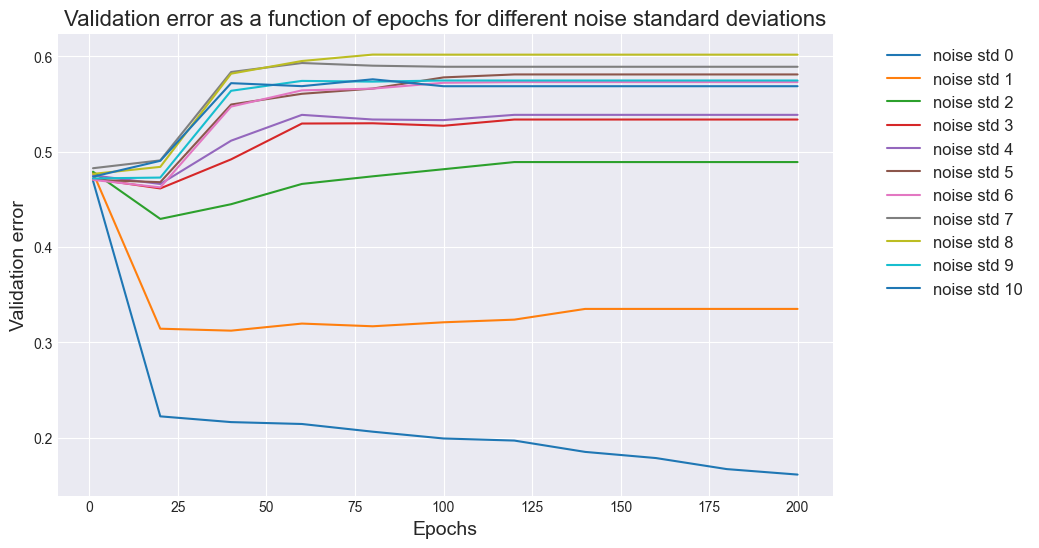

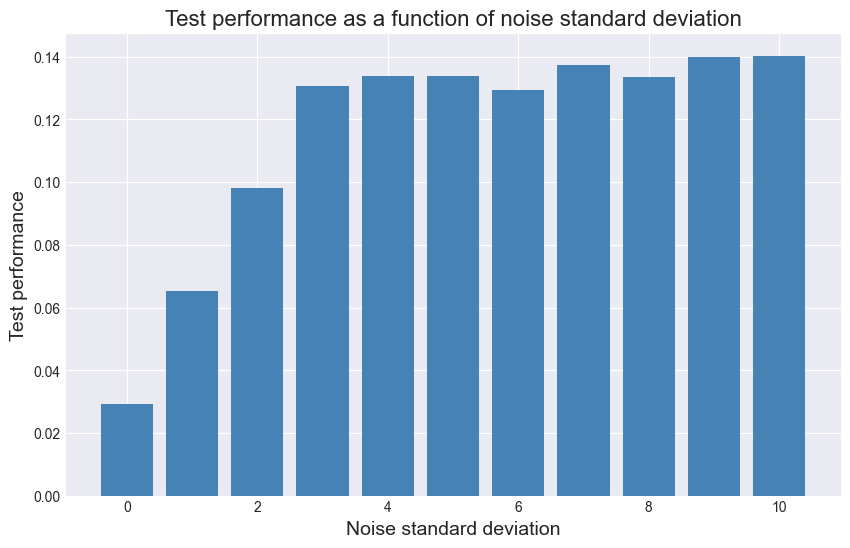

In [99]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Set a theme
plt.style.use('seaborn-darkgrid')

# Create a new figure with a custom size
fig, ax = plt.subplots(figsize=(10, 6))

# Define the epoch range
epochs = [1, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]

# Plot the validation errors for each noise standard deviation
for noise_std in sorted(validation_errors_dict_noise.keys()):
    # If the data is a tensor, convert it to a list
    if isinstance(validation_errors_dict_noise[noise_std], torch.Tensor):
        data = validation_errors_dict_noise[noise_std].tolist()
    elif isinstance(validation_errors_dict_noise[noise_std], np.ndarray):
        data = validation_errors_dict_noise[noise_std].tolist()
    else:
        data = validation_errors_dict_noise[noise_std]
        
    # Create a new list by repeating the last value of the data until its length matches the number of epochs
    extended_data = data + [data[-1]] * (len(epochs) - len(data))

    # Plot the data
    ax.plot(epochs, extended_data, label=f"noise std {noise_std}")

# Set the labels for the x and y axis
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Validation error', fontsize=14)

# Set a title for the plot
ax.set_title('Validation error as a function of epochs for different noise standard deviations', fontsize=16)

# Add a legend to the plot outside of the graph
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Show the plot
plt.show()


# Create a new figure with a custom size (you can adjust the size as needed)
fig, ax = plt.subplots(figsize=(10, 6))

# Define the noise standard deviation range and test performance
noise_range = sorted(test_performance_dict_noise.keys())
test_performance_values = [test_performance_dict_noise[noise_std] for noise_std in noise_range]

# Create the bar plot
ax.bar(noise_range, test_performance_values, color='steelblue')

# Set the labels for the x and y axis
ax.set_xlabel('Noise standard deviation', fontsize=14)
ax.set_ylabel('Test performance', fontsize=14)

# Set a title for the plot
ax.set_title('Test performance as a function of noise standard deviation', fontsize=16)

# Show the plot
plt.show()